## Trigonometric polynomials

Section 9.5

A trig polynomial of degree $n$ is
    
$$p(x) \approx \frac{a_0}{2} + \sum_{k=1}^n a_k \cos(k\pi x) + b_k \sin(k\pi x).$$

We define

$$\tau(x) = \frac{\sin(N\pi x/2)}{N\sin(\pi x/2)},$$

then a cardinal basis is $\tau_k(x) = \tau(x-x_k)$. This means that $\tau_j(x_k) = 1$ if $j=k$ and is $0$ otherwise. (Strictly we compute $\lim_{x\to 0} \tau(x)$ rather than evaluating $\tau_k(x_k)$.

The interpolating polynomial through $(x_k, y_k)$ is then $p(x) = \sum_{k=-n}^{n} y_k\tau_k(x)$.

These formulas are for the case $n$ odd. For even $n$ we make a small change. See the code below.

Here is a function that computes this interpolating polynomial:

In [1]:
"""
    triginterp(t,y)

Construct the trigonometric interpolant for the points defined by 
vectors `t` and `y`.
"""
function triginterp(t,y)
    N = length(t)

    function τ(x)
        if x==0
            return 1.0
        else
            denom = isodd(N) ? N*sin(π*x/2) : N*tan(π*x/2)
            return sin(N*π*x/2)/denom
        end
    end

    return function (x)
        sum( y[k]*τ(x-t[k]) for k in eachindex(y) )
    end
end

triginterp

Here is a plot of some cardinal basis functions (set $N$ to the value you want to show.)

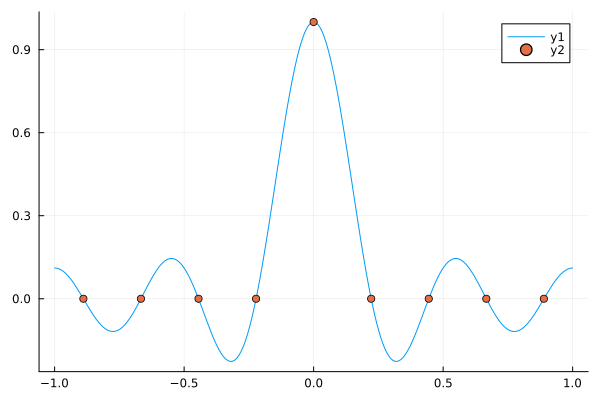

In [36]:
using Plots
N = 9;  n = (N-1)÷2  # integer divide by 2
t = 2*(-n:n)/N
y = zeros(N);  y[n+1] = 1;

plot(triginterp(t, y), -1, 1)
scatter!(t, y)

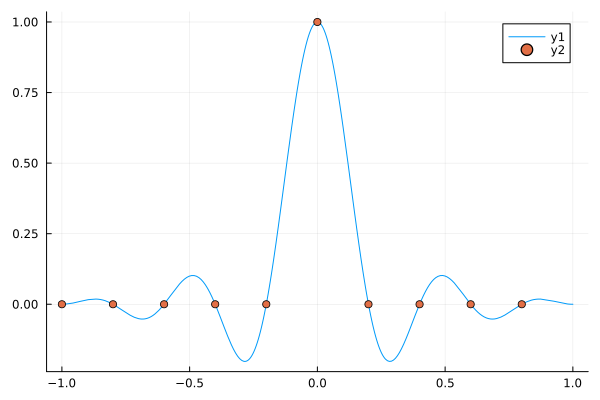

In [42]:
N = 10;  n = (N-1)÷2 + 1
t = 2*(-(n):(n-1))/N
y = zeros(N);  y[n+1] = 1;

plot(triginterp(t, y), -1, 1)
scatter!(t, y)

Here is a plot of an interpolating trigonometric polynomial. Use the $t$ defined above for the even or odd case as you prefer.

In [43]:
f(x) = sin(exp(x))
y = f.(t)
p2 = triginterp(t,y)

#1 (generic function with 1 method)

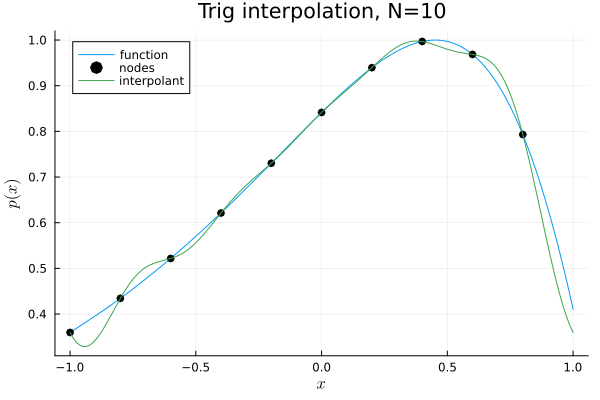

In [44]:
using LaTeXStrings
plot(f,-1,1,label="function",
    xaxis=(L"x"),yaxis=(L"p(x)"),
    title="Trig interpolation, N=$N",legend=:topleft)  
scatter!(t,y,m=:o,color=:black,label="nodes")
plot!(p2,-1,1,label="interpolant")

More examples -- both periodic and aperiodic.

In [137]:
function t_function(N)
    if iseven(N)
        n = (N-1)÷2 + 1;  t = 2*(-(n):(n-1))/N
    else
        n = (N-1)÷2     ;  t = 2*(-n:n)/N
    end
    t
end

t_function (generic function with 1 method)

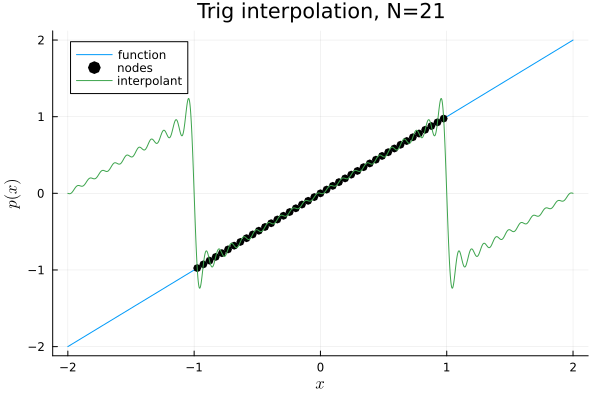

In [138]:
t = t_function(41)
f(x) = x
y = f.(t)
p3 = triginterp(t,y)
plot(f,-2,2,label="function",
    xaxis=(L"x"),yaxis=(L"p(x)"),
    title="Trig interpolation, N=$N",legend=:topleft)  
scatter!(t,y,m=:o,color=:black,label="nodes")
plot!(p3,-2,2,label="interpolant")

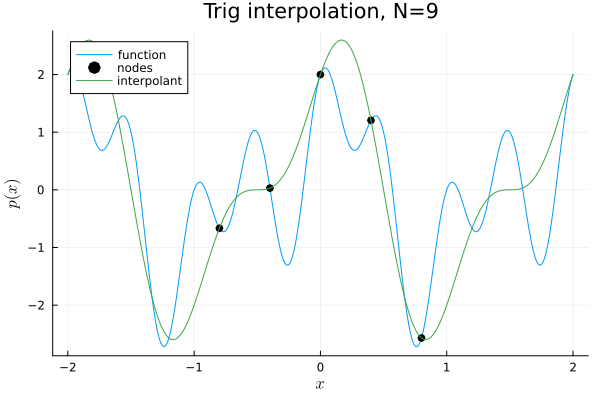

In [68]:
t = t_function(5) # change to N = 8
f(x) = cos(pi*x) + sin(2*x*pi) + cos(4*pi*x)
y = f.(t)
p3 = triginterp(t,y)
plot(f,-2,2,label="function",
    xaxis=(L"x"),yaxis=(L"p(x)"),
    title="Trig interpolation, N=$N",legend=:topleft)  
scatter!(t,y,m=:o,color=:black,label="nodes")
plot!(p3,-2,2,label="interpolant")

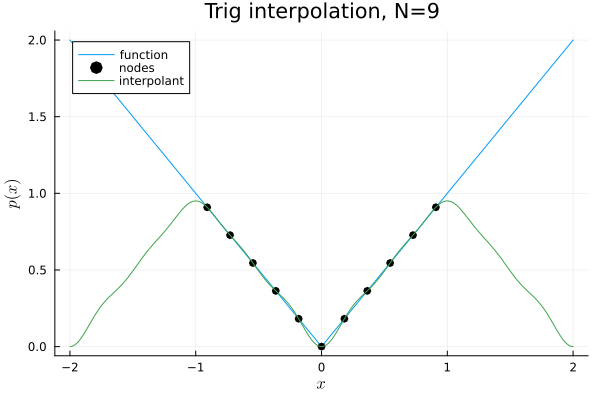

In [74]:
t = t_function(11)
f(x) = abs(x)
y = f.(t)
p3 = triginterp(t,y)
plot(f,-2,2,label="function",
    xaxis=(L"x"),yaxis=(L"p(x)"),
    title="Trig interpolation, N=$N",legend=:topleft)  
scatter!(t,y,m=:o,color=:black,label="nodes")
plot!(p3,-2,2,label="interpolant")

## Fast Fourier Transform

The Fourier transform, and the numerically efficient Fast Fourier Transform, can be used to compute these interpolating polynomials too, although the intereface and notation is somehwat different.

Here are some incomplete examples based on the textbook and the code here: https://www.matecdev.com/posts/fft-tutorial.html

The complex Fourier polynomial is 

$$p(x) = \sum_{k=-n}^n c_ke^{ik\pi x}$$

We will use real data, so we will take the real part of this polynomial. An extra factor of two in efficiency can be obtained by just using the real FFT, but I don't show that here.

In [262]:
using FFTW
using PrettyTables

In [257]:
fft_poly(c, k) = x -> real(sum(c .* exp.(im*k*x)))

fft_poly (generic function with 1 method)

In [346]:
n = 4;  N = 2n+1;
t = [ 2π * j/N for j=0:N-1 ]      # nodes in [0,2)
f0 = x -> 2*cos(x) + 3*cos(3*(x-1)) # + x ;# - exp(1im*π*x);
f2 = f0.(t) .+ 0.5 * randn(N); # optionally add some Normally distributed noise

Y = fft(f2)/N  # /N is a normalization; conventions vary across applications/disciplines
frequencies = fftfreq(N,N)
p2 = fft_poly(Y, frequencies)

#92 (generic function with 1 method)

The frequencies in the Fourier transform range from -N/2 to N/2 (-n to n here). The negative frequencies are shifted versions of the higher frequencies (originally 0 to 2N), consistent with the periodic nature of the transform. We don't need them here to reconstruct our function, but they do no harm either.

In [347]:
# freq = [0:n;-n:-1] # same as fftfreq(N,N)
data = round.(Y, sigdigits=3)
pretty_table((k=frequencies, coefficient=data), nosubheader=true)

┌──────┬──────────────────┐
│    k │      coefficient │
├──────┼──────────────────┤
│  0.0 │    -0.0437+0.0im │
│  1.0 │    1.13-0.0442im │
│  2.0 │   0.231-0.0701im │
│  3.0 │    -1.34-0.105im │
│  4.0 │ -0.0644+0.0863im │
│ -4.0 │ -0.0644-0.0863im │
│ -3.0 │    -1.34+0.105im │
│ -2.0 │   0.231+0.0701im │
│ -1.0 │    1.13+0.0442im │
└──────┴──────────────────┘


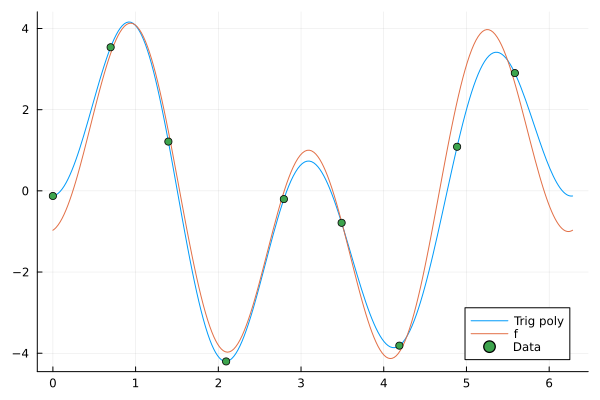

In [348]:
plot(p2, 0, 2π, label = "Trig poly")
plot!(f0, 0, 2π, label = "f")
scatter!(t, f2, label = "Data")

## Differentiating a function 

In fourier space, the linear differentiation operator becomes a multiplication. Since the exponential function is easy to differentiate, this is particularly easy to compute; just multiply the fft by the frequencies. See https://www.matecdev.com/posts/julia-fft-derivative.html

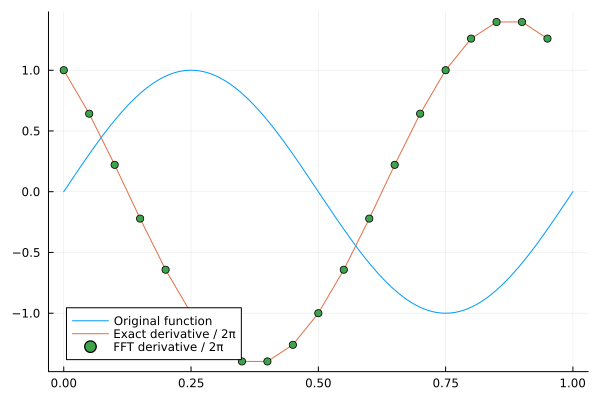

In [302]:
N = 20;
L = 1;
xj = (0:N-1)*L/N;
f2 = sin.(2π*xj)  .+ cos.(2π*xj) # .- xj # if function is not periodic, get bad approximations at the end of the domain.
df = 2π*cos.(2π*xj)  .- 2π*sin.(2π*xj) # .- 1

k = fftfreq(N)*N; # same as fftfreq(N,N)
df_fft = ifft( 2π*im/L * k .* fft(f2) ); # transform, scale, inverse transform

plot(x -> sin(2π * x), 0, 1,  label = "Original function")
plot!(xj, real(df) ./ 2π,     label = "Exact derivative / 2π")
scatter!(xj, real(df_fft) ./ 2π, label = "FFT derivative / 2π", markershape=:circle)
